
## Import libraries and reading data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df_cleaned = pd.read_parquet("aita_cleaned.parquet", engine="pyarrow")

## Generating features using TfidfVectorizer:

In [3]:
regex_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), tokenizer=regex_tokenizer.tokenize)
text_tfidf = tfidf.fit_transform(df_cleaned['body'])

## Train test split

In [4]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [10]:
def print_score(true, pred):
    print("Test Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Precision Score: {precision_score(true, pred, average='weighted') * 100:.2f}%")
    print("_______________________________________________")
    print(f"Recall Score: {recall_score(true, pred, average='weighted') * 100:.2f}%")
    print("_______________________________________________")
    print(f"F1 Score: {f1_score(true, pred, average='weighted') * 100:.2f}%")

In [6]:
X = text_tfidf
y = df_cleaned['adjudication']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## Build models and evaluate

### Logistic regrestion

In [25]:
log_reg = LogisticRegression()
start = time.time()
log_reg.fit(X_train, y_train)
end = time.time()
log_reg_runtime = end - start
y_pred_log_reg = log_reg.predict(X_test)

In [26]:
print_score(y_test, y_pred_log_reg)

Test Result:
Accuracy Score: 73.74%
_______________________________________________
Precision Score: 68.27%
_______________________________________________
Recall Score: 73.74%
_______________________________________________
F1 Score: 66.38%


### XGBoost

In [13]:
xgb_clf = XGBClassifier()
start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
xgb_clf_runtime = end - start
y_pred_xgb_clf = xgb_clf.predict(X_test)

In [14]:
print_score(y_test, y_pred_xgb_clf)

Test Result:
Accuracy Score: 73.52%
_______________________________________________
Precision Score: 66.56%
_______________________________________________
Recall Score: 73.52%
_______________________________________________
F1 Score: 64.55%


### Random Forest

In [16]:
rf_clf = RandomForestClassifier()
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
rf_clf_runtime = end - start
y_pred_rf_clf = rf_clf.predict(X_test)

In [17]:
print_score(y_test, y_pred_rf_clf)

Test Result:
Accuracy Score: 73.82%
_______________________________________________
Precision Score: 74.86%
_______________________________________________
Recall Score: 73.82%
_______________________________________________
F1 Score: 62.73%


### KNN

In [51]:
knn_clf = KNeighborsClassifier()
start = time.time()
knn_clf.fit(X_train, y_train)
end = time.time()
knn_clf_runtime = end - start
y_pred_knn_clf = knn_clf.predict(X_test)

In [52]:
print_score(y_test, y_pred_knn_clf)

Test Result:
Accuracy Score: 69.55%
_______________________________________________
Precision Score: 63.41%
_______________________________________________
Recall Score: 69.55%
_______________________________________________
F1 Score: 65.13%


## Compare

In [72]:
time_dict = {
    'Logistic Regression': log_reg_runtime,
    'XGBoost': xgb_clf_runtime,
    'Random Forest': rf_clf_runtime,
    'KNN': knn_clf_runtime,
}

accuracy_dict = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log_reg),
    'XGBoost': accuracy_score(y_test, y_pred_xgb_clf),
    'Random Forest': accuracy_score(y_test, y_pred_rf_clf),
    'KNN': accuracy_score(y_test, y_pred_knn_clf),
}

precision_dict = {
    'Logistic Regression': precision_score(y_test, y_pred_log_reg, average='weighted'),
    'XGBoost': precision_score(y_test, y_pred_xgb_clf, average='weighted'),
    'Random Forest': precision_score(y_test, y_pred_rf_clf, average='weighted'),
    'KNN': precision_score(y_test, y_pred_knn_clf, average='weighted'),
}

recall_dict = {
    'Logistic Regression': recall_score(y_test, y_pred_log_reg, average='weighted'),
    'XGBoost': recall_score(y_test, y_pred_xgb_clf, average='weighted'),
    'Random Forest': recall_score(y_test, y_pred_rf_clf, average='weighted'),
    'KNN': recall_score(y_test, y_pred_knn_clf, average='weighted'),
}

f1_dict = {
    'Logistic Regression': f1_score(y_test, y_pred_log_reg, average='weighted'),
    'XGBoost': f1_score(y_test, y_pred_xgb_clf, average='weighted'),
    'Random Forest': f1_score(y_test, y_pred_rf_clf, average='weighted'),
    'KNN': f1_score(y_test, y_pred_knn_clf, average='weighted'),
}

### Accuracy

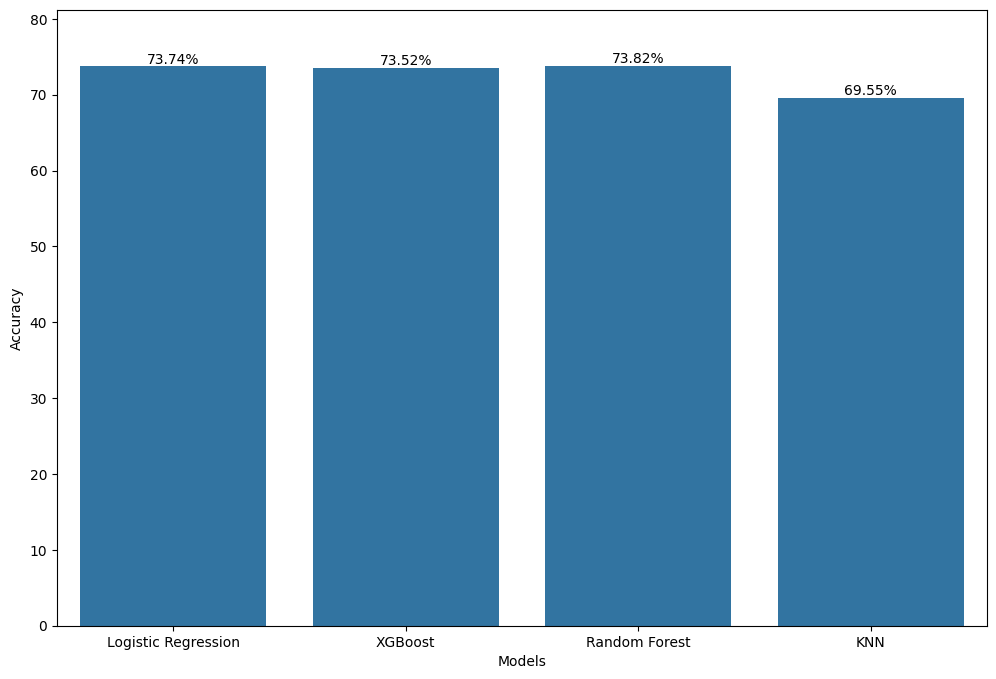

In [60]:
accuracy_df = pd.DataFrame({'Models':accuracy_dict.keys(), 'Accuracy':accuracy_dict.values()})
accuracy_df['Accuracy'] = accuracy_df['Accuracy']*100
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Models', y='Accuracy', data=accuracy_df, ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f%%', label_type='edge')
ax.margins(y=0.1)

### Precision

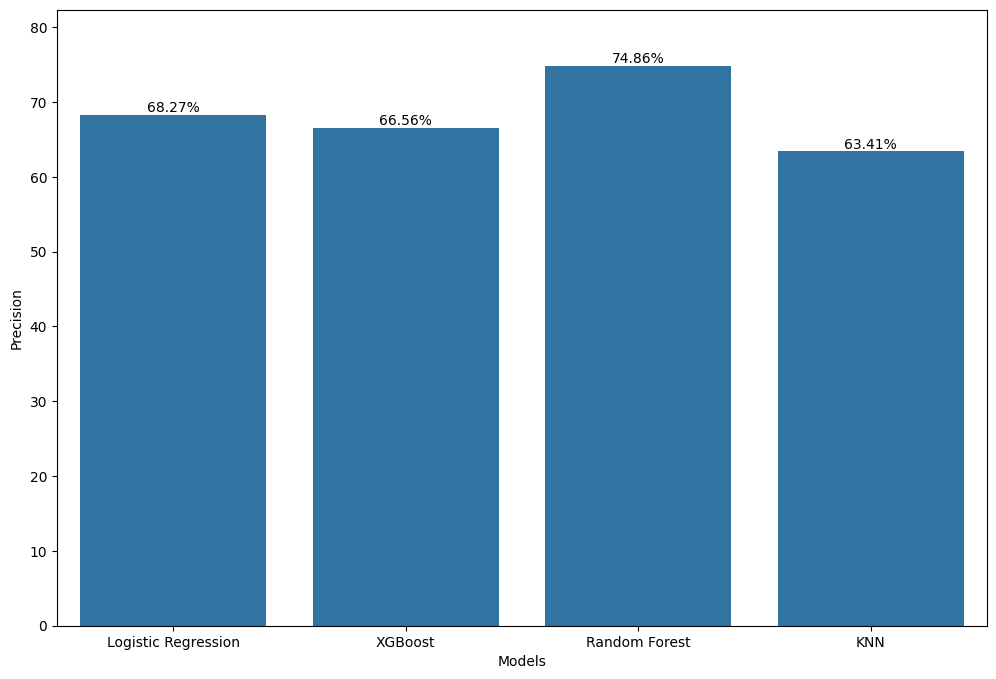

In [61]:
precision_df = pd.DataFrame({'Models':precision_dict.keys(), 'Precision':precision_dict.values()})
precision_df['Precision'] = precision_df['Precision']*100
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Models', y='Precision', data=precision_df, ax=ax)
ax.bar_label(ax.containers[0], fmt='%0.2f%%', label_type='edge')
ax.margins(y=0.1)

### Recall

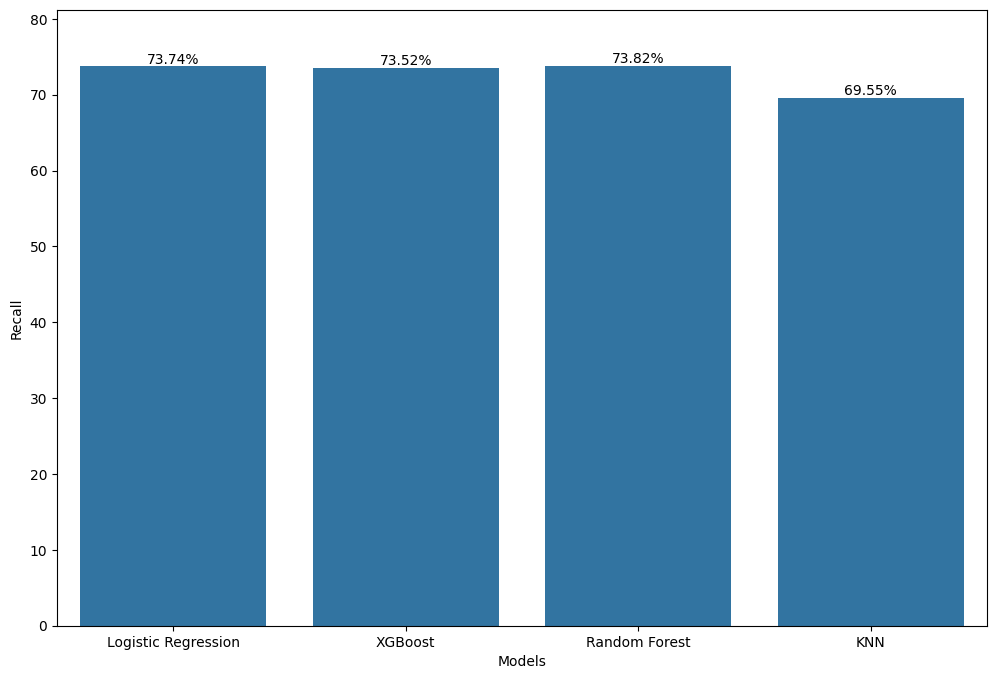

In [62]:
recall_df = pd.DataFrame({'Models':recall_dict.keys(), 'Recall':recall_dict.values()})
recall_df['Recall'] = recall_df['Recall']*100
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Models', y='Recall', data=recall_df, ax=ax)
ax.bar_label(ax.containers[0], fmt='%0.2f%%', label_type='edge')
ax.margins(y=0.1)

### F1 Score

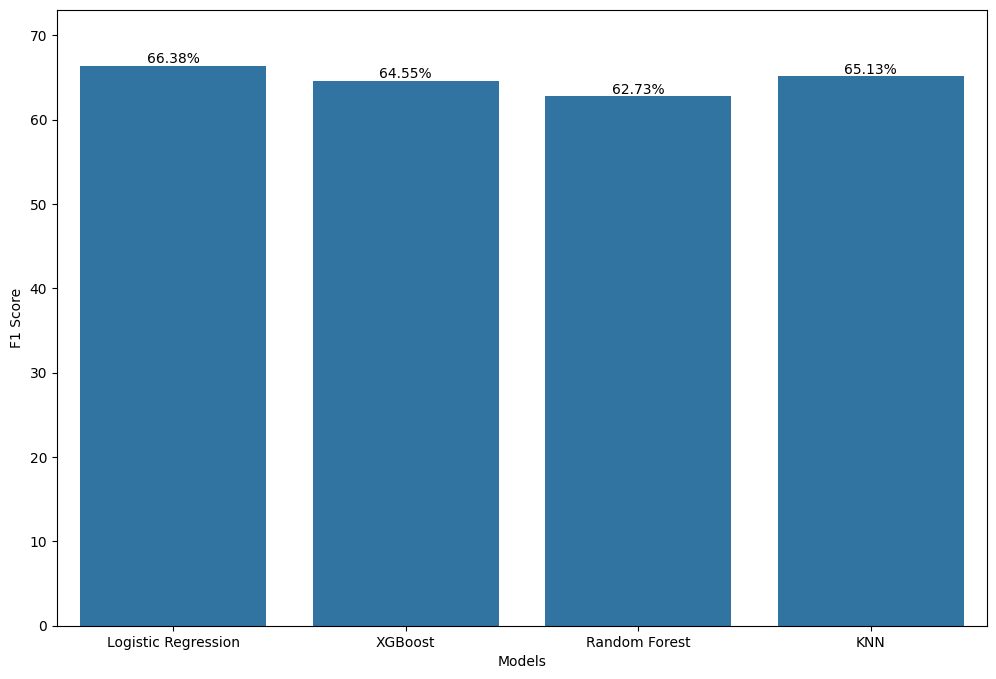

In [68]:
f1_df = pd.DataFrame({'Models':f1_dict.keys(), 'F1 Score':f1_dict.values()})
f1_df['F1 Score'] = f1_df['F1 Score']*100
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Models', y='F1 Score', data=f1_df, ax=ax)
ax.bar_label(ax.containers[0], fmt='%0.2f%%', label_type='edge')
ax.margins(y=0.1)

### Runtime

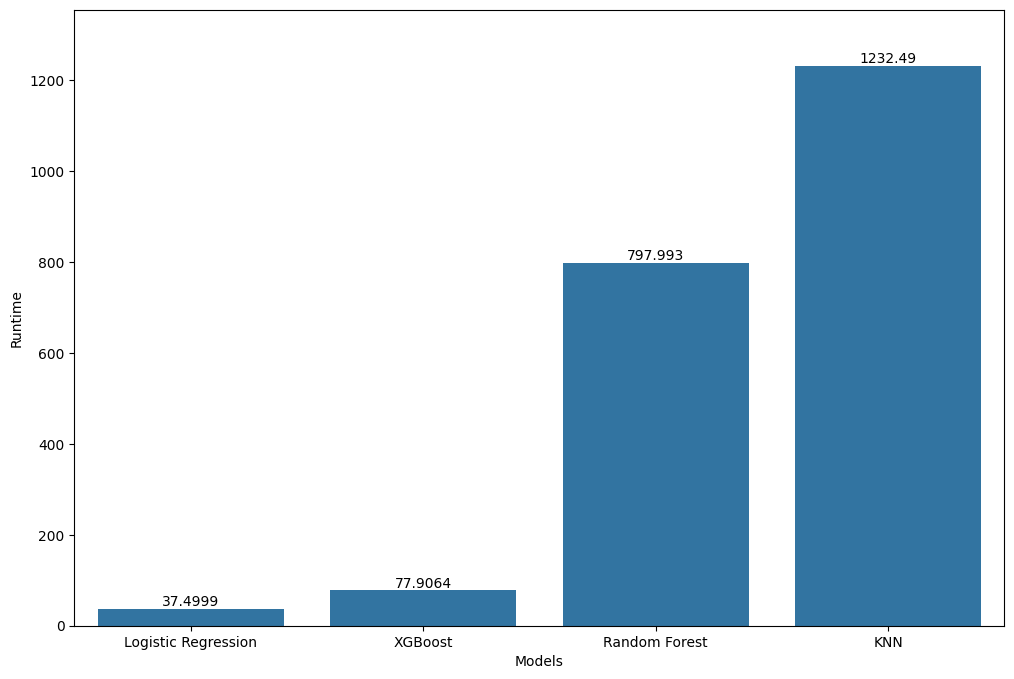

In [73]:
time_df = pd.DataFrame({'Models':time_dict.keys(), 'Runtime':time_dict.values()})
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Models', y='Runtime', data=time_df, ax=ax)
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)

## KFold for best model

In [74]:
log_reg_kf = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = cross_val_predict(log_reg_kf, X, y, cv=kf)

## Demo